In [1]:
import kagglehub

try:
    # Attempt to download the latest version of the dataset
    path = kagglehub.dataset_download("ziqiangg/nuimages")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Download failed: {e}")
    print("You might need to set up Kaggle API credentials.")

Using Colab cache for faster access to the 'nuimages' dataset.
Path to dataset files: /kaggle/input/nuimages


In [2]:
import os

# Define paths based on kagglehub cache location
KAGGLE_CACHE_ROOT = "/root/.cache/kaggle/input/nuimages"
PROJ_ROOT = KAGGLE_CACHE_ROOT  # We'll use the cache root as the project root
META_DIR  = f"{PROJ_ROOT}"
DATA_DIR  = f"{PROJ_ROOT}"
CROPS_DIR = f"{DATA_DIR}/crops/crops"  # Based on your path: /root/.../crops/crops

print("Data location for training:", CROPS_DIR)
print("Data size:")
!du -sh "$CROPS_DIR"

Data location for training: /root/.cache/kaggle/input/nuimages/crops/crops
Data size:
3.3G	/root/.cache/kaggle/input/nuimages/crops/crops


In [27]:
import pandas as pd
import numpy as np
import json, random
from PIL import Image, ImageOps, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms, models
import itertools

import matplotlib.pyplot as plt

#training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

#gradCAM
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from collections import defaultdict
import torch.nn.functional as F

#metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
import seaborn as sns

# high-D feature space visualisation
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
import umap


#local
MANIFEST_PATH   = f"{META_DIR}/manifest.csv"
CLASSES_JSON    = f"{META_DIR}/classes.json"

SEED = 42


In [4]:
def seed_everything(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Deterministic kernels (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # If you need *strict* determinism (may error on some ops):
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Make each worker deterministic (NumPy / Python RNG too)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

seed_everything(SEED)

In [6]:
with open(CLASSES_JSON, "r") as f:
    classes_meta = json.load(f)

# Expecting a "classes" list with fields: id, name, display_name, ...
name_to_id = {c["name"]: c["id"] for c in classes_meta["classes"]}
id_to_name = {c["id"]: c["name"] for c in classes_meta["classes"]}
index_order = classes_meta.get("index_order", [c["name"] for c in classes_meta["classes"]])

print("Classes (name -> id):", name_to_id)

Classes (name -> id): {'car': 0, 'truck': 1, 'bus': 2, 'trailer': 3, 'construction_vehicle': 4, 'pedestrian': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic_cone': 8, 'barrier': 9}


In [7]:
df = pd.read_csv(MANIFEST_PATH)

IOU_THR = 0.60
IOA_THR = 0.60

clean_df = df.query("max_cross_iou < @IOU_THR and max_cross_ioa < @IOA_THR").reset_index(drop=True)

print("Kept rows:", len(clean_df), "of", len(df), " | -", len(df)-len(clean_df))
print(clean_df["class"].value_counts(dropna=False))


Kept rows: 163739 of 172178  | - 8439
class
car                     81346
barrier                 18540
truck                   16709
pedestrian              15299
traffic_cone             8172
bicycle                  7110
motorcycle               7101
bus                      3628
construction_vehicle     3601
trailer                  2233
Name: count, dtype: int64


In [8]:
# Majority (primary) class per image, to stratify at image level
img_class_counts = (clean_df.groupby(["img_path","class"])
                    .size().reset_index(name="n"))
major = (img_class_counts.sort_values(["img_path","n"], ascending=[True, False])
                      .drop_duplicates("img_path"))
img2label = dict(zip(major["img_path"], major["class"]))

groups = clean_df["img_path"].values
y_img  = clean_df["img_path"].map(img2label).values

def stratified_group_split70_15_15(df, y=None, groups=None, seed=42):
    """
    Leak-proof 70/15/15 split:
      - one row per unique img_path (primary/majority class per image)
      - stratify on image-level primary class
      - map image splits back to crop rows
    """
    # 1) Image-level table with primary label
    img_tab = (df.groupby(['img_path','class'])
                 .size().reset_index(name='n')
                 .sort_values(['img_path','n'], ascending=[True, False])
                 .drop_duplicates('img_path'))
    imgs = img_tab['img_path'].values
    yimg = img_tab['class'].values

    # 2) Train 70% vs Temp 30% (stratified by image primary class)
    imgs_train, imgs_temp, y_train, y_temp = train_test_split(
        imgs, yimg, train_size=0.70, random_state=seed, stratify=yimg
    )

    # 3) Temp → Val/Test 50/50 (≈15/15 overall), stratified
    imgs_val, imgs_test, y_val, y_test = train_test_split(
        imgs_temp, y_temp, train_size=0.50, random_state=seed, stratify=y_temp
    )

    # 4) Map back to crop rows
    s_train, s_val, s_test = set(imgs_train), set(imgs_val), set(imgs_test)
    train_df = df[df['img_path'].isin(s_train)].reset_index(drop=True)
    val_df   = df[df['img_path'].isin(s_val)].reset_index(drop=True)
    test_df  = df[df['img_path'].isin(s_test)].reset_index(drop=True)

    # 5) Sanity: zero leakage
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    assert len(a & b) == 0 and len(a & c) == 0 and len(b & c) == 0, "Leakage across splits!"

    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_group_split70_15_15(clean_df, y_img, groups, seed=SEED)

def _summary(df, name):
    print(f"{name:5s} rows={len(df):6d}  images={df['img_path'].nunique():5d}")
    print(df["class"].value_counts(dropna=False),"\n")

def leakage_ok(train_df, val_df, test_df):
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    print("train∩val:", len(a & b), "  train∩test:", len(a & c), "  val∩test:", len(b & c))

_summary(train_df, "train")
_summary(val_df,   "val")
_summary(test_df,  "test")
leakage_ok(train_df, val_df, test_df)  # should all be 0


train rows=114965  images=39745
class
car                     57174
barrier                 12921
truck                   11722
pedestrian              10868
traffic_cone             5715
motorcycle               4998
bicycle                  4987
bus                      2535
construction_vehicle     2506
trailer                  1539
Name: count, dtype: int64 

val   rows= 24335  images= 8517
class
car                     12012
barrier                  2843
truck                    2479
pedestrian               2203
traffic_cone             1240
bicycle                  1051
motorcycle               1051
construction_vehicle      562
bus                       561
trailer                   333
Name: count, dtype: int64 

test  rows= 24439  images= 8517
class
car                     12160
barrier                  2776
truck                    2508
pedestrian               2228
traffic_cone             1217
bicycle                  1072
motorcycle               1052
construction_vehicle

In [9]:
def attach_abs_paths(df):
    """Optimized path resolution to local storage"""
    def resolve(p):
        p = str(p).strip().lstrip("./")
        # Already absolute -> keep
        if os.path.isabs(p) or p.startswith("/content/drive"):
            return os.path.normpath(p)
        # Manifest stored "data/crops/..."
        if p.startswith("data/crops/"):
            rel = p.split("data/", 1)[1]          # -> "crops/..."
            return os.path.normpath(os.path.join(DATA_DIR, rel))
        # Manifest stored "crops/..."
        if p.startswith("crops/"):
            rel = p.split("crops/", 1)[1]         # -> e.g. "traffic_cone/xxx.jpg"
            return os.path.normpath(os.path.join(CROPS_DIR, rel))
        # Default: treat relative to LOCAL_CROPS_DIR
        return os.path.normpath(os.path.join(CROPS_DIR, p))

    out = df.copy()
    out["__abs_path__"] = out["crop_path"].apply(resolve)
    mask = out["__abs_path__"].apply(os.path.exists)
    missing = int((~mask).sum())
    if missing:
        print(f"[warn] {missing} crop files resolved to non-existent paths (filtered out).")
    return out[mask].reset_index(drop=True)

class Letterbox224:
    """
    Resize preserving aspect ratio and pad to 224x224.
    - Uses high-quality BICUBIC upsampling for small crops.
    - Pads with black (0) by default (works fine with ImageNet normalization later).
    """
    def __init__(self, size=224, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if w == 0 or h == 0:
            # create a dummy black image to avoid crashes
            return Image.new("RGB", (self.size, self.size), self.fill)

        scale = min(self.size / w, self.size / h)  # fit within square
        nw, nh = max(1, int(round(w * scale))), max(1, int(round(h * scale)))
        # Resize with antialiasing (BICUBIC is good for upscaling small crops)
        img = img.resize((nw, nh), Image.BICUBIC)

        # pad to square canvas
        new_im = Image.new("RGB", (self.size, self.size), self.fill)
        left = (self.size - nw) // 2
        top  = (self.size - nh) // 2
        new_im.paste(img, (left, top))
        return new_im

def collate_skip_none(batch):
    """Drop samples that failed to load/transform."""
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    xs, ys = zip(*batch)
    return torch.stack(xs, 0), torch.tensor(ys)

In [10]:
train_df_ = attach_abs_paths(train_df)
val_df_   = attach_abs_paths(val_df)
test_df_  = attach_abs_paths(test_df)

letterbox = Letterbox224(224, fill=0)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    letterbox,
    # ADDED BY ROBIN
    transforms.RandomHorizontalFlip(p=0.5),      # Horizontal flip 0.5
    transforms.RandomVerticalFlip(p=0.5),        # Vertical flip 0.5
    transforms.RandomRotation(degrees=36),       # Rotate 0.2 * 180 = 36 degrees
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Random zoom 0.2 (0.8 to 1.2x)
    # END
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    letterbox,
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [11]:
class NuCropsDataset(Dataset):
    def __init__(self, frame, label_map, transform, report_small=True, small_thresh=12):
        self.df = frame.reset_index(drop=True)
        self.lm = label_map
        self.t = transform
        self.report_small = report_small
        self.small_thresh = small_thresh
        self._small_seen = 0

        # Pre-compute all labels to avoid dictionary lookup during training
        self.labels = [self.lm[r["class"]] for _, r in self.df.iterrows()]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        # Direct access instead of df.iloc[i] which is slow
        path = self.df.iloc[i]["__abs_path__"]
        y = self.labels[i]  # Pre-computed, no lookup needed

        try:
            with Image.open(path) as im:
                im = im.convert("RGB")
                if self.report_small:
                    w, h = im.size
                    if w < self.small_thresh or h < self.small_thresh:
                        self._small_seen += 1
                x = self.t(im) if self.t else im
        except Exception as e:
            # Skip unreadable images without crashing the batch
            return None
        return x, y

train_ds = NuCropsDataset(train_df_, label_map=name_to_id, transform=train_tfms)
val_ds   = NuCropsDataset(val_df_,   label_map=name_to_id, transform=eval_tfms, report_small=False)
test_ds  = NuCropsDataset(test_df_,  label_map=name_to_id, transform=eval_tfms, report_small=False)

In [12]:
BATCH = 24
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,                 # reproducible because we seed + pass generator
    num_workers=8,
    pin_memory=False,
    collate_fn=collate_skip_none,
    worker_init_fn=seed_worker,
    generator=g,                  # <-- important
    persistent_workers=False,     # keep False for simplest determinism
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False, num_workers=8,
    pin_memory=False, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH, shuffle=False, num_workers=8,
    pin_memory=False, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

# Quick peek
batch = next(iter(train_loader))
if batch is None:
    print("[warn] first batch was empty after skipping Nones — try again or check data.")
else:
    xb, yb = batch
    print("train batch:", tuple(xb.shape), tuple(yb.shape))  # e.g., (24, 3, 224, 224)

train batch: (24, 3, 224, 224) (24,)


# ResNet50 Transfer Learning (Frozen Backbone Version)
Implementing a pretrained ResNet50 model with frozen backbone and selective unfreezing for transfer learning.

---
**Initial Data Augmentation:**

* Letterboxing to 224x224 pixels
* Horizontal flip=0.5
* Vertical flip=0.5
* Rotate=0.2 * 180 = 36 degrees
* Random zoom=0.2 (0.8 to 1.2x)
* Mean Normalisation using ImageNet statistics (mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225])

---

**Model Specifications:**

1. **Input tensor:** (batch_size, 3, 224, 224)
2. **Multiclass classification output:** 10 classes (uses SoftMax activation function for output layer)
3. **Pretrained backbone:** ResNet50 with ImageNet1K_V1 weights
4. **Freezing strategy:** Frozen backbone with only last 2 layers trainable

---

**Feature Extractor:**

3. **ResNet50 Backbone:**
   * **Initial layers:** Frozen (all conv layers, batch norms, etc. from conv1 through layer3)
   * **Last conv block:** Unfrozen (layer4 - final residual block)
   * **Final BatchNorm/ReLU:** Unfrozen (after layer4)
   * **Global Average Pooling:** Frozen (part of original ResNet50 architecture)

---

**Classifier:**

4. **Fully Connected Layer:**
   * **FC Layer:** Input=2048 (ResNet50 features), Output=10 classes
   * **Activation:** Linear (no activation - CrossEntropy handles SoftMax internally)
   * **Trainable:** True (replaces original 1000-class classifier)

---

**Training Configuration:**

1. **Loss Function:** CrossEntropy Loss

2. **Optimizer:** Adam with learning rate = 0.001
   * **Parameter filtering:** Only optimizes trainable parameters (layer4 + final FC layer)

3. **Learning Rate Scheduler:** ReduceLROnPlateau
   * Mode: 'min'
   * Patience: 3
   * Factor: 0.5

4. **Early Stopping:** Monitor validation loss with patience = 3, min_delta = 0.001

5. **Trainable Parameters:**

   * **Total params:** ~25.6M (full ResNet50)
   * **Trainable params:** ~2.5M (layer4 + final classifier)
   * **Percentage trainable:** ~9.8%



In [14]:
def create_frozen_resnet50(num_classes=10):
    """
    Create ResNet-50 with frozen backbone, only training last 2 layers
    """
    model = models.resnet50(weights='IMAGENET1K_V1')  # Pretrained weights

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of features from the last layer before classifier
    num_features = model.fc.in_features

    # Replace the final classifier with new one for 10 classes
    model.fc = nn.Linear(num_features, num_classes)

    # Unfreeze the final layer (classifier)
    model.fc.weight.requires_grad = True
    model.fc.bias.requires_grad = True

    # Unfreeze the last conv block (layer4 + final BN/ReLU) - last 2 layers to train
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Count trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

    return model

# Create the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model1 = create_frozen_resnet50(num_classes=10)
model1 = model1.to(device)

# Setup optimizer - only optimize trainable parameters
optimizer1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=0.001)

# Setup scheduler
scheduler1 = ReduceLROnPlateau(optimizer1, mode='min', patience=3, factor=0.5)

# Setup criterion
criterion = nn.CrossEntropyLoss()


# Early stopping setup
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

early_stopping1 = EarlyStopping(patience=3, min_delta=0.001)

print("Model setup complete!")
print(f"Device: {device}")
print(f"Optimizer: Adam with initial LR=0.001")
print(f"Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
print(f"Early Stopping: patience=10, min_delta=0.001")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Total params: 23,528,522
Trainable params: 14,985,226
Percentage trainable: 63.69%
Model setup complete!
Device: cuda:0
Optimizer: Adam with initial LR=0.001
Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
Early Stopping: patience=10, min_delta=0.001


In [15]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training', leave=False)
    for batch in pbar:
        if batch is None:
            continue  # Skip empty batches

        data, targets = batch
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        accuracy = 100. * correct / total
        pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.2f}%'})

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Validating', leave=False)
    with torch.no_grad():
        for batch in pbar:
            if batch is None:
                continue  # Skip empty batches

            data, targets = batch
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            accuracy = 100. * correct / total
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.2f}%'})

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, device, num_epochs=100):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<10} {'Val Loss':<12} {'Val Acc':<10} {'LR':<10}")
    print("-" * 70)

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print metrics
        current_lr = optimizer.param_groups[0]['lr']
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<10.2f}% {val_loss:<12.4f} {val_acc:<10.2f}% {current_lr:<10.6f}")

        # Check early stopping
        if early_stopping(val_loss):
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


In [16]:
# Train the model with progress bars
train_losses1, train_accs1, val_losses1, val_accs1 = train_model(
    model1, train_loader, val_loader, criterion, optimizer1, scheduler1, early_stopping1, device
)

MODEL1_SAVE_PATH = "/content/nuimages_resnet50_frozen.pth"
torch.save(model1.state_dict(), MODEL1_SAVE_PATH)
print(f"Model successfully saved to: {MODEL1_SAVE_PATH}")

Epoch  Train Loss   Train Acc  Val Loss     Val Acc    LR        
----------------------------------------------------------------------


1      0.4667       84.56     % 0.3308       89.40     % 0.001000  


2      0.3444       88.56     % 0.2947       90.62     % 0.001000  


3      0.3035       89.82     % 0.2684       91.51     % 0.001000  


4      0.2808       90.74     % 0.2714       91.46     % 0.001000  


5      0.2626       91.27     % 0.2496       92.01     % 0.001000  


6      0.2472       91.65     % 0.2406       92.53     % 0.001000  


7      0.2364       92.07     % 0.2417       92.34     % 0.001000  


8      0.2270       92.33     % 0.2322       92.76     % 0.001000  


9      0.2157       92.72     % 0.2257       92.97     % 0.001000  


10     0.2097       92.92     % 0.2201       93.02     % 0.001000  


11     0.2022       93.20     % 0.2125       93.35     % 0.001000  


12     0.1963       93.38     % 0.2217       93.15     % 0.001000  


13     0.1911       93.59     % 0.2231       93.14     % 0.001000  


14     0.1826       93.85     % 0.2224       93.23     % 0.001000  

Early stopping triggered at epoch 14
Model successfully saved to: /content/nuimages_resnet50_frozen.pth


# ResNet50 Transfer Learning (Classifier Only Version)
Implementing a pretrained ResNet50 model with completely frozen backbone and only classifier trainable for ablation study.

---
**Model Specifications:**

1. **Input tensor:** (batch_size, 3, 224, 224)
2. **Pretrained backbone:** ResNet50 with ImageNet1K_V1 weights
3. **Freezing strategy:** Complete backbone frozen, only final classifier trainable

---

**Feature Extractor:**

3. **ResNet50 Backbone:**
   * **All layers:** Frozen (conv1 through layer4, batch norms, global average pooling)
   * **No trainable parameters** in feature extraction layers

---

**Classifier:**

4. **Fully Connected Layer:**
   * **FC Layer:** Input=2048, Output=10 classes
   * **Trainable:** True (only trainable component)

---

**Training Configuration:**

1. **Trainable Parameters:**
   * **Total params:** ~25.6M
   * **Trainable params:** ~20K (only classifier weights + bias)
   * **Percentage trainable:** ~0.08%

2. **Optimizer:** Adam with learning rate = 0.001 (only classifier parameters)

In [17]:
def create_fully_frozen_resnet50(num_classes=10):
    """
    Create ResNet-50 with completely frozen backbone, only training classifier
    """
    model = models.resnet50(weights='IMAGENET1K_V1')  # Pretrained weights

    # Freeze ALL layers in the backbone
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of features from the last layer before classifier
    num_features = model.fc.in_features

    # Replace the final classifier with new one for 10 classes
    model.fc = nn.Linear(num_features, num_classes)

    # Unfreeze ONLY the final classifier layer
    model.fc.weight.requires_grad = True
    model.fc.bias.requires_grad = True

    # Count trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

    return model

# Create the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2 = create_fully_frozen_resnet50(num_classes=10)
model2 = model2.to(device)

# Setup optimizer - only optimize classifier parameters
optimizer2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)

# Create FRESH scheduler and early stopping for this model
scheduler2 = ReduceLROnPlateau(optimizer2, mode='min', patience=3, factor=0.5)
early_stopping2 = EarlyStopping(patience=3, min_delta=0.001)

Total params: 23,528,522
Trainable params: 20,490
Percentage trainable: 0.09%


In [18]:
# Training loop for full frozen backbone
train_losses2, train_accs2, val_losses2, val_accs2 = train_model(
    model2, train_loader, val_loader, criterion, optimizer2, scheduler2, early_stopping2, device
)

# save model
MODEL2_SAVE_PATH = "/content/nuimages_resnet50_frozenall.pth"
torch.save(model2.state_dict(), MODEL2_SAVE_PATH)
print(f"Model successfully saved to: {MODEL2_SAVE_PATH}")

Epoch  Train Loss   Train Acc  Val Loss     Val Acc    LR        
----------------------------------------------------------------------


1      0.7313       76.44     % 0.6136       79.77     % 0.001000  


2      0.6611       78.56     % 0.5525       81.85     % 0.001000  


3      0.6376       79.37     % 0.5405       82.04     % 0.001000  


4      0.6252       79.74     % 0.4858       84.04     % 0.001000  


5      0.6082       80.26     % 0.5761       82.59     % 0.001000  


6      0.6079       80.19     % 0.5056       83.37     % 0.001000  


7      0.5993       80.55     % 0.5733       81.50     % 0.001000  

Early stopping triggered at epoch 7
Model successfully saved to: /content/nuimages_resnet50_frozenall.pth


#Evaluation of Both Models


In [19]:
def evaluate_model(model, test_loader, device, model_name="Model", id_to_name=None):
    """
    Comprehensive evaluation of model including confusion matrices and metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            if batch is None:
                continue
            data, targets = batch
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Raw Confusion Matrix
    cm_raw = confusion_matrix(all_targets, all_predictions)

    # Normalized Confusion Matrix (Per-Class Accuracy %)
    cm_normalized = confusion_matrix(all_targets, all_predictions, normalize='true')

    # Classification Report (Precision, Recall, F1)
    class_report = classification_report(all_targets, all_predictions, output_dict=True)

    # Per-metric table
    metrics_table = {
        'Class': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'Support': []
    }

    for class_idx in range(len(class_report)-3):  # Exclude 'accuracy', 'macro avg', 'weighted avg'
        if id_to_name and class_idx in id_to_name:
            class_name = id_to_name[class_idx]
        else:
            class_name = str(class_idx)
        metrics_table['Class'].append(class_name)
        metrics_table['Precision'].append(class_report[str(class_idx)]['precision'])
        metrics_table['Recall'].append(class_report[str(class_idx)]['recall'])
        metrics_table['F1-Score'].append(class_report[str(class_idx)]['f1-score'])
        metrics_table['Support'].append(class_report[str(class_idx)]['support'])

    return cm_raw, cm_normalized, class_report, metrics_table, all_predictions, all_targets


def plot_confusion_matrix(cm, title, class_names=None, normalize=False):
    """
    Plot confusion matrix heatmap
    """
    plt.figure(figsize=(8, 6))
    if normalize:
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{title} (Normalized - Per-Class Accuracy %)')
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{title} (Raw Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, title):
    """
    Plot training and validation loss/accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(val_accs, label='Val Accuracy', color='red')
    ax2.set_title(f'{title} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
# Load and evaluate Model 1 (Frozen backbone, last 2 layers + classifier trainable)
model1 = create_frozen_resnet50(num_classes=10)
model1.load_state_dict(torch.load("/content/nuimages_resnet50_frozen.pth"))
model1 = model1.to(device)

cm1_raw, cm1_norm, report1, metrics1, pred1, target1 = evaluate_model(
    model1, test_loader, device, "Partially Frozen ResNet50", id_to_name
)

# Load and evaluate Model 2 (Completely frozen backbone, only classifier trainable)
model2 = create_fully_frozen_resnet50(num_classes=10)
model2.load_state_dict(torch.load("/content/nuimages_resnet50_frozenall.pth"))
model2 = model2.to(device)

cm2_raw, cm2_norm, report2, metrics2, pred2, target2 = evaluate_model(
    model2, test_loader, device, "Fully Frozen ResNet50", id_to_name
)



Total params: 23,528,522
Trainable params: 14,985,226
Percentage trainable: 63.69%


Evaluating Partially Frozen ResNet50: 100%|██████████| 1019/1019 [00:40<00:00, 25.44it/s]


Total params: 23,528,522
Trainable params: 20,490
Percentage trainable: 0.09%


Evaluating Fully Frozen ResNet50: 100%|██████████| 1019/1019 [00:39<00:00, 25.64it/s]



Raw Confusion Matrix Heatmaps:


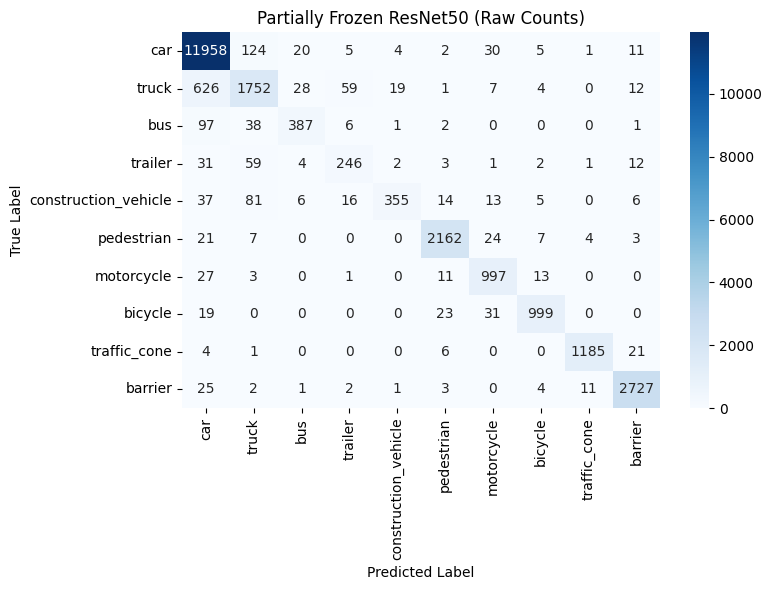

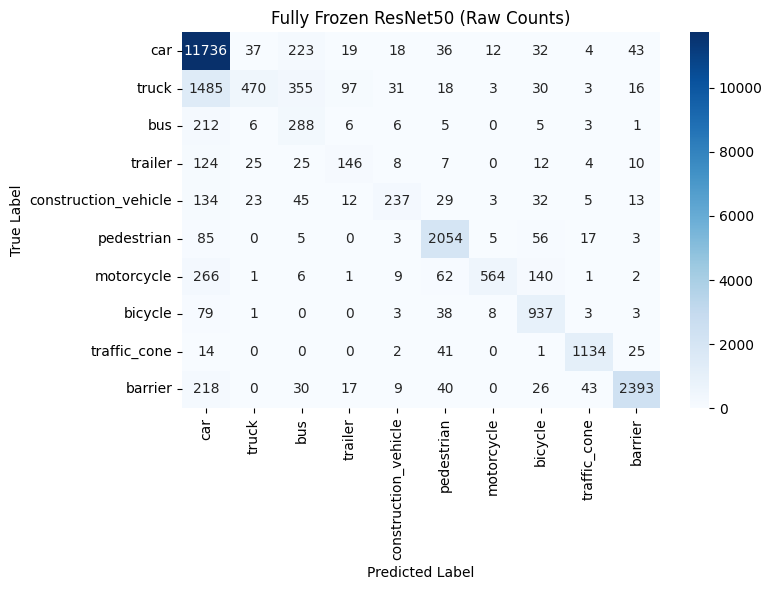


Normalized Confusion Matrix Heatmaps:


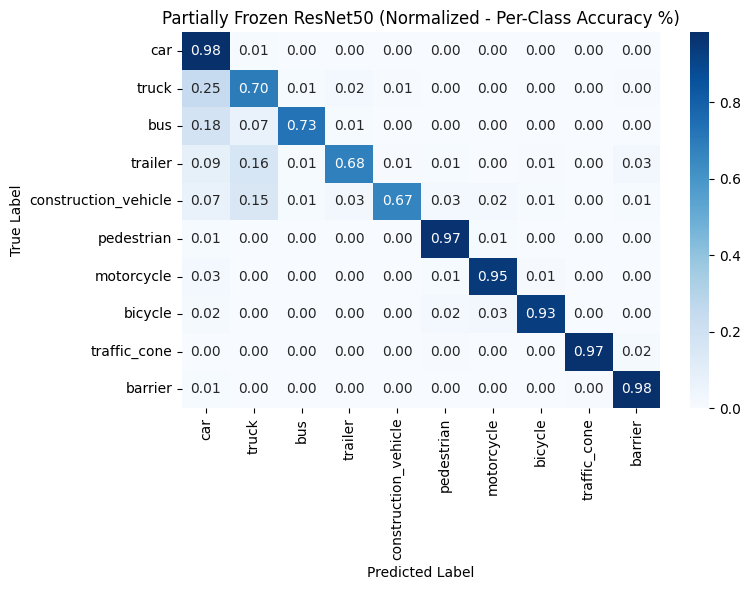

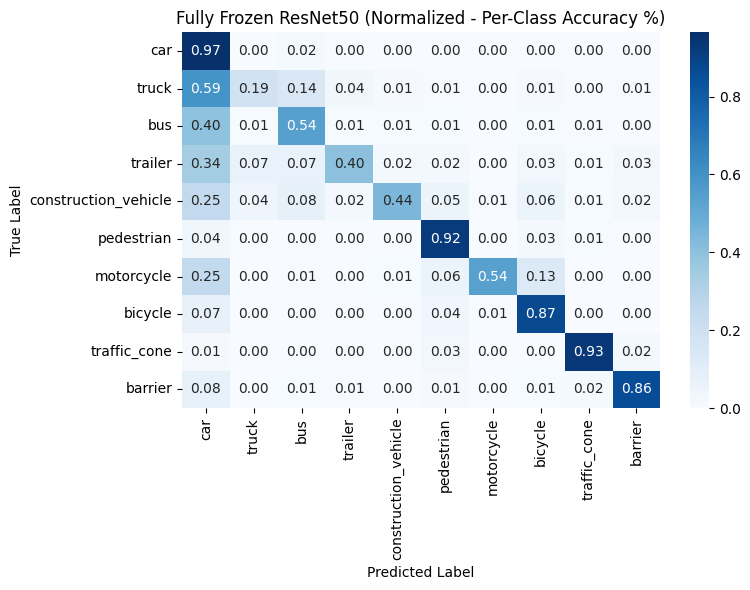

In [21]:
# Plot confusion matrices using class names
class_names = [id_to_name[i] for i in range(10)]

print("\nRaw Confusion Matrix Heatmaps:")
plot_confusion_matrix(cm1_raw, "Partially Frozen ResNet50", class_names, normalize=False)
plot_confusion_matrix(cm2_raw, "Fully Frozen ResNet50", class_names, normalize=False)

print("\nNormalized Confusion Matrix Heatmaps:")
plot_confusion_matrix(cm1_norm, "Partially Frozen ResNet50", class_names, normalize=True)
plot_confusion_matrix(cm2_norm, "Fully Frozen ResNet50", class_names, normalize=True)

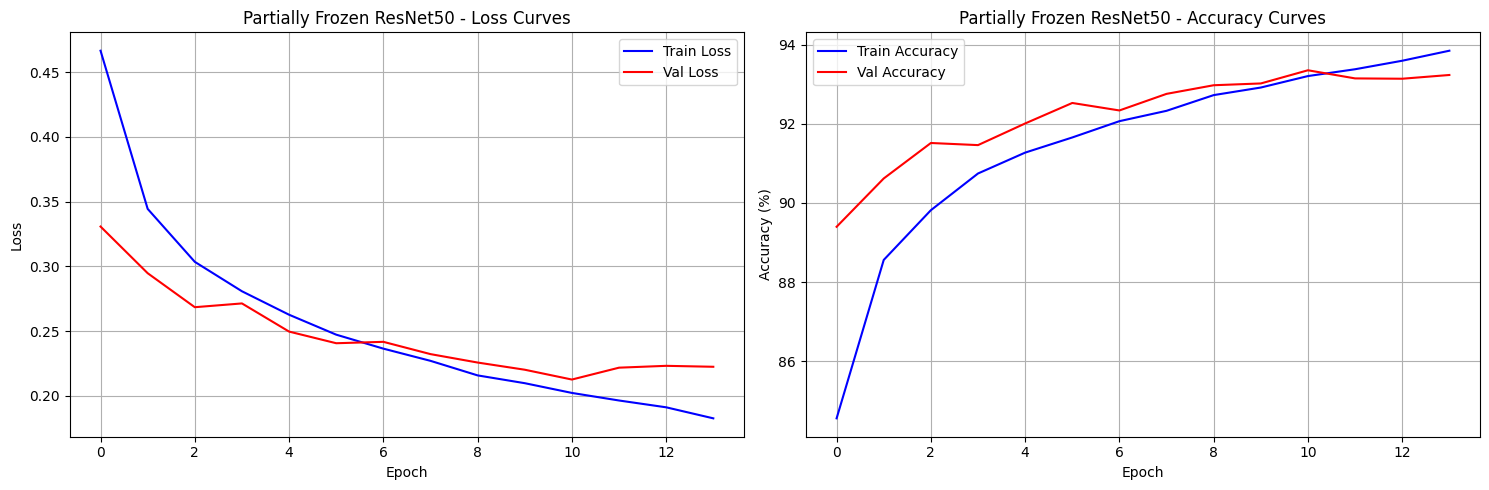

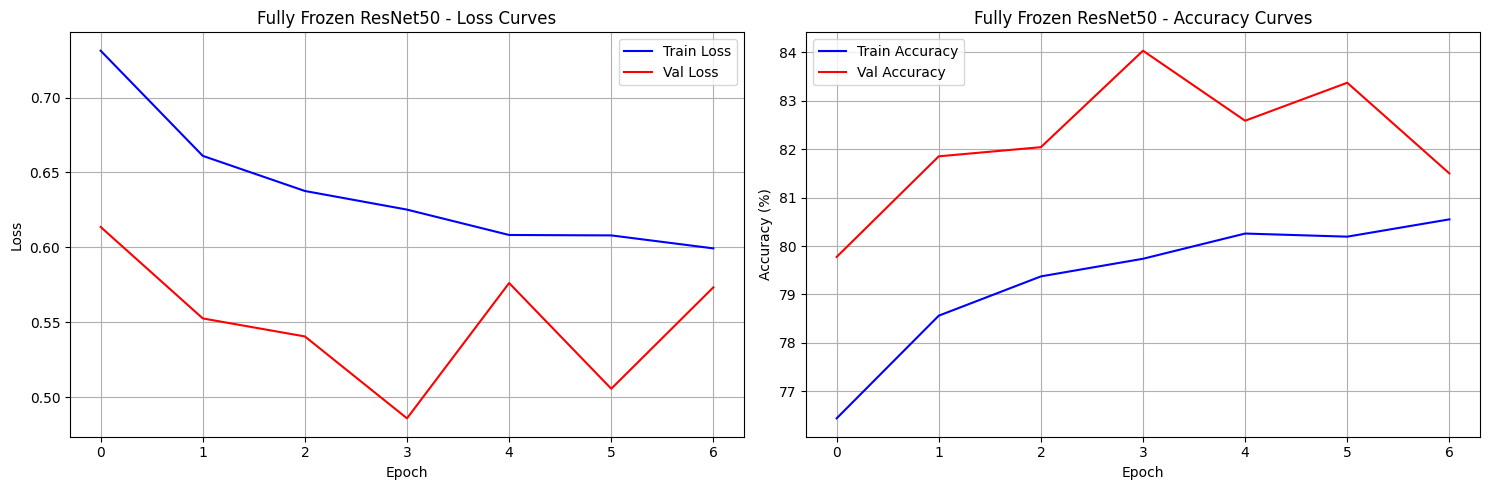

In [22]:
# Plot individual curves
plot_training_curves(train_losses1, val_losses1, train_accs1, val_accs1, "Partially Frozen ResNet50")
plot_training_curves(train_losses2, val_losses2, train_accs2, val_accs2, "Fully Frozen ResNet50")

In [39]:
# Display metrics tables
print("\nPartially Frozen ResNet50 - Per-Metric Table:")
df1 = pd.DataFrame(metrics1)
df1['Precision'] = df1['Precision'].round(3)
df1['Recall'] = df1['Recall'].round(3)
df1['F1-Score'] = df1['F1-Score'].round(3)
print(df1)

print("\nFully Frozen ResNet50 - Per-Metric Table:")
df2 = pd.DataFrame(metrics2)
df2['Precision'] = df2['Precision'].round(3)
df2['Recall'] = df2['Recall'].round(3)
df2['F1-Score'] = df2['F1-Score'].round(3)
print(df2)


Partially Frozen ResNet50 - Per-Metric Table:
                  Class  Precision  Recall  F1-Score  Support
0                   car      0.931   0.983     0.956  12160.0
1                 truck      0.848   0.699     0.766   2508.0
2                   bus      0.868   0.727     0.791    532.0
3               trailer      0.734   0.681     0.707    361.0
4  construction_vehicle      0.929   0.666     0.776    533.0
5            pedestrian      0.971   0.970     0.971   2228.0
6            motorcycle      0.904   0.948     0.925   1052.0
7               bicycle      0.962   0.932     0.946   1072.0
8          traffic_cone      0.986   0.974     0.980   1217.0
9               barrier      0.976   0.982     0.979   2776.0

Fully Frozen ResNet50 - Per-Metric Table:
                  Class  Precision  Recall  F1-Score  Support
0                   car      0.818   0.965     0.885  12160.0
1                 truck      0.835   0.187     0.306   2508.0
2                   bus      0.295   0.541

From the normalised confusion matrix for both Fully Frozen and Partially Frozen (last layer unfrozen) models. We can draw some observations,

The Partially Frozen Model Outperforms Fully Frozen Model Overall and is much better at generalising the dataset. To note



*   Truck: 70% vs 59% (raw counts = 16709)

*   Bus: 73% vs 54% (raw counts = 3628)

*   Trailer: 68% vs 40% (raw counts = 2233)

*   Construction Vehicle: 67% vs 44% (raw counts = 3601)

*   Motorcycle: 95% vs 54% (raw counts = 7101)

Unfreezing the last convolutional block (layer4) significantly improves classification performance, especially for imbalanced classes like bus, trailer, construction vehicle, motorcycle, and barrier. Although an outlier would be trucks which had the 3rd highest class representation but still performed relatively poorly amongst all classes in both models. This also points to a larger issue where the model is unable to distinguish similar looking vehicles (truck, bus, construction vehicle & trailers) which have ambiguous boundaries.

---

From the training vs validation loss and accuracy curves for both models,

Partially frozen: Both train and val loss decrease smoothly and steadily, and scheduler decreases lr slower. → model is learning well.

Fully frozen: Train loss decreases slowly, val loss fluctuates (dips then rises), and scheduler decreases lr earlier → signs of instability or overfitting to the classifier.

---

Next we will visualise the attention maps of both models to allow us to interpret what the model prioritises in making decisions.



#GradCam Attention Maps

In [25]:
def run_gradcam_for_model(model, model_name, device, test_loader, id_to_name):
    """
    Run GradCAM visualization for a given model
    """
    target_layer_name = "layer4.2"

    try:
        cam_extractor = GradCAM(model, target_layer_name, input_shape=(3, 224, 224))
        print(f"Successfully initialized GradCAM for {model_name} target layer: {target_layer_name}")
    except ValueError as e:
        print(f"Failed to initialize GradCAM for layer '{target_layer_name}': {e}")
        print("Trying fallback layer 'layer4'...")
        target_layer_name = "layer4"
        try:
            cam_extractor = GradCAM(model, target_layer_name, input_shape=(3, 224, 224))
            print(f"Successfully initialized GradCAM for {model_name} fallback target layer: {target_layer_name}")
        except ValueError as e2:
            print(f"Failed again with fallback layer '{target_layer_name}': {e2}")
            print("Please check the model architecture to identify the correct last conv layer name.")
            print(model.layer4) # Print the structure to help identify the correct layer
            return None

    # Prepare to store 3 images per class
    images_per_class = defaultdict(list)
    max_images_per_class = 3

    # Iterate through the test set to collect images and their GradCAMs
    model.eval()
    found_classes = set()

    for batch_idx, (data, target) in enumerate(test_loader):
        if data is None:
            continue
        data, target = data.to(device), target.to(device)

        # Get predictions
        output = model(data)
        predicted = output.max(1, keepdim=True)[1]

        # Process each item in the batch
        for i in range(data.shape[0]):
            pred_class = predicted[i].item()
            true_class = target[i].item()

            # Only store images if we haven't reached the limit for this class yet
            if len(images_per_class[true_class]) < max_images_per_class:
                img_tensor = data[i].unsqueeze(0) # Shape: (1, C, H, W)

                # Get the model output for this specific image
                out = model(img_tensor)

                # Compute softmax probabilities
                probs = F.softmax(out, dim=1).squeeze(0)  # Shape: [10]
                prob_values = probs.detach().cpu().numpy()
                predicted_prob = prob_values[pred_class]

                # Get the GradCAM for the predicted class
                activation_maps = cam_extractor(class_idx=pred_class, scores=out)

                # Extract the activation map for the first (and only) image in the batch
                activation_map_tensor = activation_maps[0]

                # Handle the activation map tensor shape and type
                if activation_map_tensor.dim() > 2:
                    activation_map_tensor = activation_map_tensor.squeeze()
                    if activation_map_tensor.dim() > 2:
                        activation_map_tensor = activation_map_tensor.mean(dim=0)
                elif activation_map_tensor.dim() < 2:
                    print(f"Warning: Activation map tensor has unexpected low dimensions: {activation_map_tensor.dim()}")
                    continue

                # Ensure the tensor is on CPU and convert to numpy
                activation_map_np = activation_map_tensor.cpu().numpy()

                # Normalize the activation map values to [0, 1] for PIL
                v_min, v_max = activation_map_np.min(), activation_map_np.max()
                if v_max - v_min != 0:
                    activation_map_np = (activation_map_np - v_min) / (v_max - v_min)
                else:
                    activation_map_np = np.zeros_like(activation_map_np)

                # Convert to PIL Image
                try:
                    cam_pil = Image.fromarray(activation_map_np)
                except TypeError:
                    activation_map_uint8 = (activation_map_np * 255).astype(np.uint8)
                    cam_pil = Image.fromarray(activation_map_uint8)

                # Convert tensor image back to a displayable format (un-normalize)
                denorm_transform = transforms.Compose([
                    transforms.Normalize(mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
                                         std=[1/s for s in IMAGENET_STD]),
                    transforms.ToPILImage()
                ])
                img_pil = denorm_transform(img_tensor.squeeze(0).cpu())

                # Overlay the CAM mask on the original image
                result = overlay_mask(img_pil, cam_pil, alpha=0.5)

                # Store the original image, the GradCAM result, and the predicted class name
                images_per_class[true_class].append({
                    'original': img_pil,
                    'gradcam': result,
                    'predicted_name': id_to_name[pred_class],
                    'true_name': id_to_name[true_class],
                    'softmax_probs': prob_values,
                    'predicted_prob': predicted_prob
                })

                # Add the class to the found set
                found_classes.add(true_class)

        # Check if we have collected enough images for all 10 classes
        if len(found_classes) == 10 and all(len(images) >= max_images_per_class for images in images_per_class.values()):
            print(f"Collected {max_images_per_class} images for all {len(images_per_class)} classes for {model_name}.")
            break

    # Display the collected images
    fig, axes = plt.subplots(max_images_per_class, 10, figsize=(20, 8))  # 3 rows, 10 columns

    # Ensure all class IDs from 0 to 9 are represented
    for class_id in range(10):  # assuming classes are 0-9
        class_name = id_to_name.get(class_id, f"Class_{class_id}")
        collected_images = images_per_class.get(class_id, [])

        for row_idx in range(max_images_per_class):
            ax = axes[row_idx, class_id]
            if row_idx < len(collected_images):
                img_info = collected_images[row_idx]
                ax.imshow(img_info['gradcam'])
                conf = img_info['predicted_prob']
                ax.set_title(f'{class_name}\n→ {img_info["predicted_name"]}\n({conf:.2%})', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'N/A', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes, fontsize=10)
            ax.axis('off')

    plt.suptitle(f'GradCAM Visualization - {model_name} (Overlaid on Original Images)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Clean up gradcam hooks
    if 'cam_extractor' in locals() and cam_extractor is not None:
        try:
            cam_extractor.remove_hooks()
            print(f"Grad-CAM hooks successfully removed for {model_name}.")
        except Exception as e:
            print(f"Warning: Failed to remove Grad-CAM hooks for {model_name}: {e}")

    return images_per_class

Loading Fully Frozen ResNet50 for GradCAM...
Total params: 23,528,522
Trainable params: 20,490
Percentage trainable: 0.09%
Running GradCAM for Partially Frozen ResNet50...
Successfully initialized GradCAM for Partially Frozen ResNet50 target layer: layer4.2
Collected 3 images for all 10 classes for Partially Frozen ResNet50.


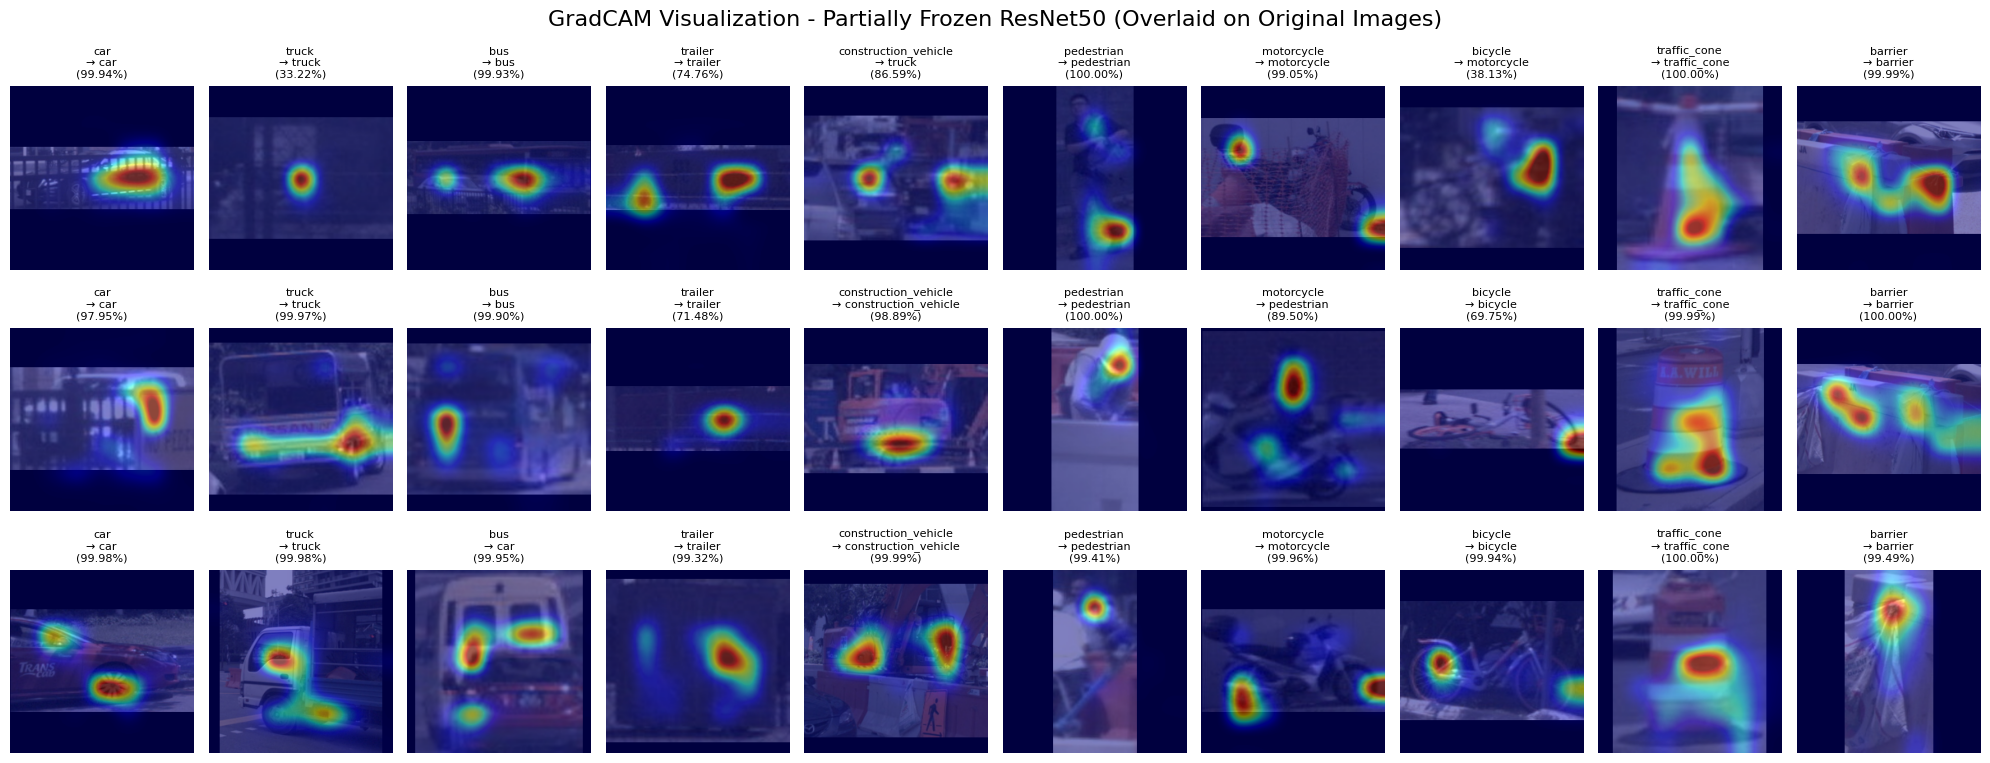

Grad-CAM hooks successfully removed for Partially Frozen ResNet50.

Running GradCAM for Fully Frozen ResNet50...
Successfully initialized GradCAM for Fully Frozen ResNet50 target layer: layer4.2
Collected 3 images for all 10 classes for Fully Frozen ResNet50.


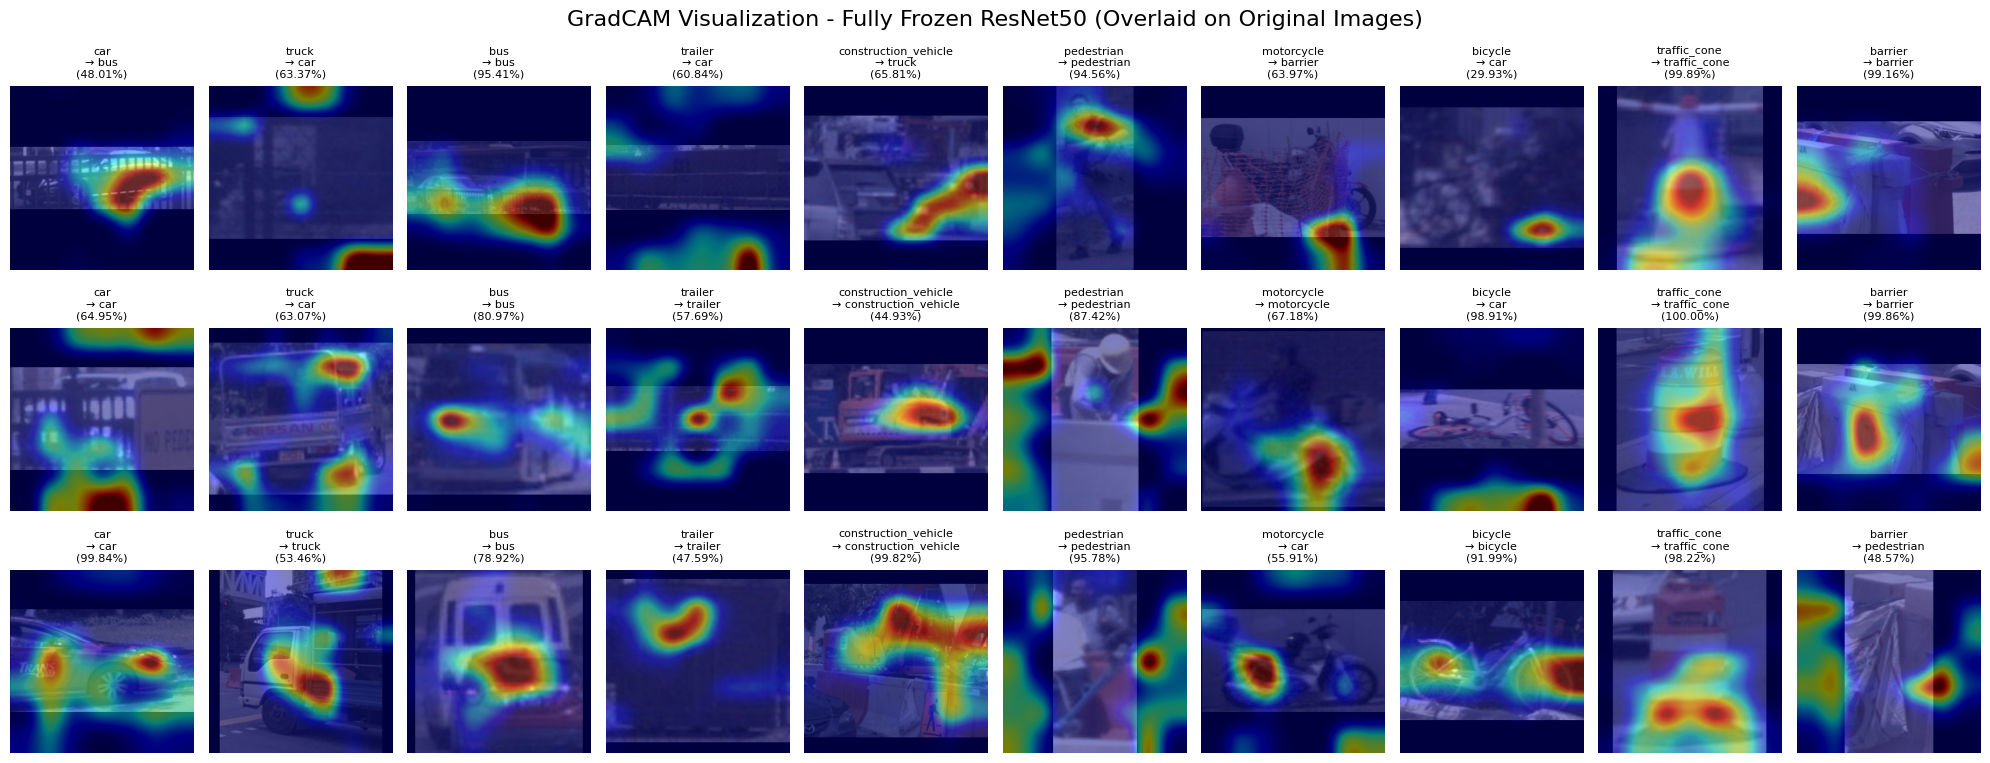

Grad-CAM hooks successfully removed for Fully Frozen ResNet50.


In [34]:
# For the fully frozen model, enable gradients for the target layer
# Reload the fully frozen model and enable gradients for the target layer
print("Loading Fully Frozen ResNet50 for GradCAM...")
model2_for_gradcam = create_fully_frozen_resnet50(num_classes=10)
model2_for_gradcam.load_state_dict(torch.load("/content/nuimages_resnet50_frozenall.pth"))
model2_for_gradcam = model2_for_gradcam.to(device)

# Enable gradients for the target layer (layer4) for GradCAM to work
for param in model2_for_gradcam.layer4.parameters():
    param.requires_grad = True

# Run GradCAM for Partially Frozen Model
print("Running GradCAM for Partially Frozen ResNet50...")
gradcam_results1 = run_gradcam_for_model(model1, "Partially Frozen ResNet50", device, test_loader, id_to_name)

# Run GradCAM for Fully Frozen Model (with temporary gradient enable)
print("\nRunning GradCAM for Fully Frozen ResNet50...")
gradcam_results2 = run_gradcam_for_model(model2_for_gradcam, "Fully Frozen ResNet50", device, test_loader, id_to_name)



Partially Frozen Model is much better at identifying concentrated and relevant portions of the image that reveal the ground truth class, where as the Fully Frozen tends to stray to black padded regions in the 224x224 images.

#High Dimensional Feature Map

In [37]:
def visualize_feature_space(model, test_loader, device, id_to_name, model_name):
    model.eval()
    features = []
    labels = []

    # Extract features from the layer before classifier (last layer features)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if data is None:
                continue
            data, target = data.to(device), target.to(device)

            # Get features before the final classifier (this is the global average pooled features from layer4)
            # This corresponds to the features right before the classifier
            x = model.conv1(data)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            # Global average pooling
            x = model.avgpool(x)
            feat = torch.flatten(x, 1)  # This is the feature vector before classifier

            features.append(feat.cpu().numpy())
            labels.extend(target.cpu().numpy())

    features = np.vstack(features)
    labels = np.array(labels)

    # t-SNE visualization
    print(f"Running t-SNE for {model_name} with {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.1)
    plt.colorbar(scatter)
    plt.title(f'Last Layer Feature Space Visualization (t-SNE) - {model_name}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')

    # Add legend
    class_names = [id_to_name[i] for i in range(10)]
    handles = [plt.scatter([], [], c=plt.cm.tab10(i), alpha=0.6, label=class_names[i]) for i in range(10)]
    plt.legend(handles=handles, labels=class_names, bbox_to_anchor=(1.3, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Total params: 23,528,522
Trainable params: 20,490
Percentage trainable: 0.09%
Visualizing Last Layer Feature Space - Partially Frozen ResNet50...
Running t-SNE for Partially Frozen ResNet50 with 24439 samples...


/tmp/ipython-input-60856474.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i), alpha=0.6, label=class_names[i]) for i in range(10)]


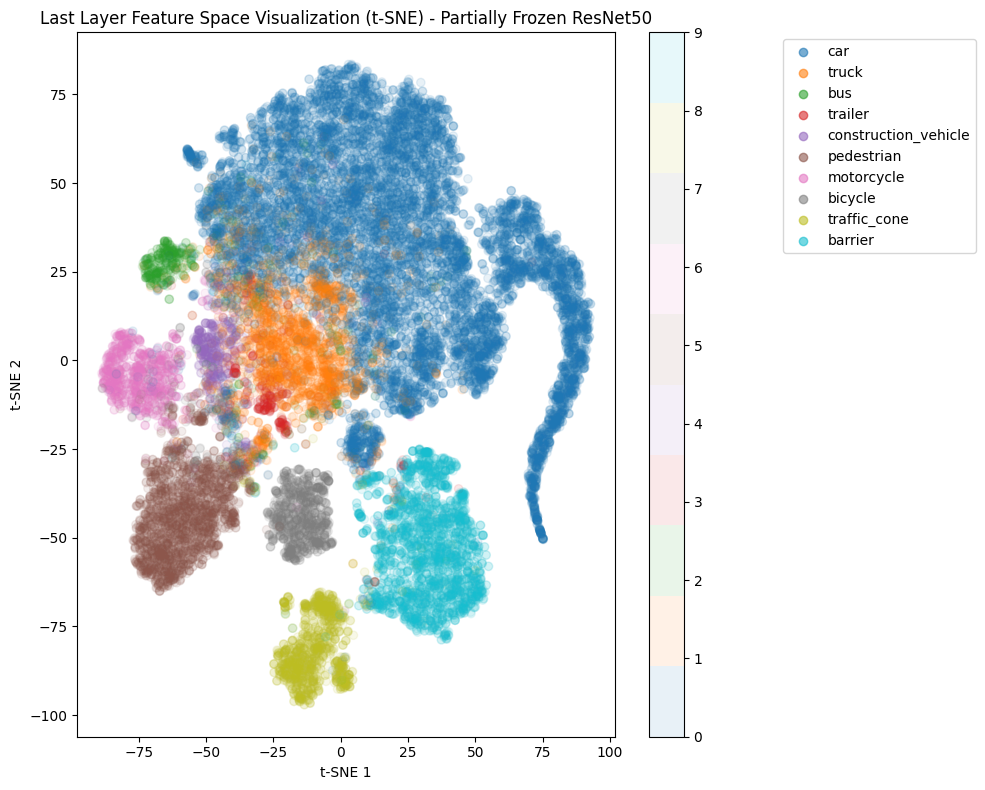


Visualizing Last Layer Feature Space - Fully Frozen ResNet50...
Running t-SNE for Fully Frozen ResNet50 with 24439 samples...


/tmp/ipython-input-60856474.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i), alpha=0.6, label=class_names[i]) for i in range(10)]


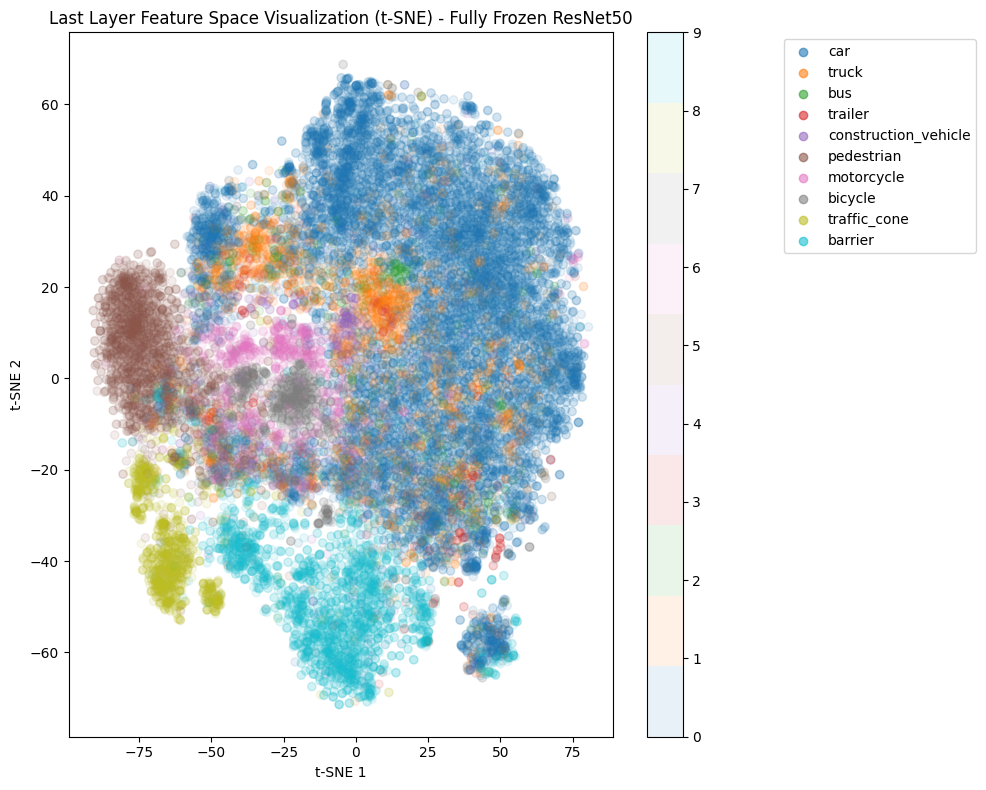

In [38]:
model2_for_features = create_fully_frozen_resnet50(num_classes=10)
model2_for_features.load_state_dict(torch.load("/content/nuimages_resnet50_frozenall.pth"))
model2_for_features = model2_for_features.to(device)

model2_for_features.eval()

print("Visualizing Last Layer Feature Space - Partially Frozen ResNet50...")
visualize_feature_space(model1, test_loader, device, id_to_name, "Partially Frozen ResNet50")

print("\nVisualizing Last Layer Feature Space - Fully Frozen ResNet50...")
visualize_feature_space(model2_for_features, test_loader, device, id_to_name, "Fully Frozen ResNet50")

The TSNE reduced feature space of the partially frozen model a clear class boundary between most classes, except for cars, trucks, construction vehicles and trailers.

---

On the other hand, as expected, the Frozen Model had more ambiguous class boundaries.

#Conclusions

1.  When the backbone is frozen, the classifier tries to compensate by learning arbitrary mappings — which works for easy classes (car, pedestrian) but fails for complex ones.

2. Allowing gradient flow through layer4 creates a more robust, adaptable model.

3. Some underrepresented / ambiguous classes like trailer, bus and construction vehicles may require further augementation / regularisation to boost results for these classes

4. Trucks were the 3rd highest represented class but performed relatively badly with the 4th lowest F1 score (0.766) in the Partial Frozen Model.

